In [9]:
import pandas as pd
import numpy as np
import verispy, os
from verispy import VERIS
import seaborn as sns
from util import constants as cst
import matplotlib.pyplot as plt

[Source for VERISPY + Useful README](https://github.com/RiskLens/verispy)

In [10]:
DATA_DIR ="./data/validated"
v = VERIS(json_dir=DATA_DIR)
vdf = v.json_to_df(keep_raw=True)
print(vdf.shape)

Found 8363 json files.
Loading schema


 32%|███▏      | 2671/8363 [00:00<00:00, 26707.29it/s]

Loading JSON files to DataFrame.


  0%|          | 0/173 [00:00<?, ?it/s]

Finished loading JSON files to dataframe.
Building DataFrame with enumerations.
Building enumeration columns.


100%|██████████| 173/173 [00:07<00:00, 24.55it/s]


Done building DataFrame with enumerations.
Post-Processing DataFrame (A4 Names, Victim Industries, Patterns)
Finished building VERIS DataFrame
(8363, 2347)


##### v is a VERIS object. vdf contains the actual data. 

In [11]:

vdf.rename(columns={'attribute.confidentiality.data_total': 'records_lost'}, inplace=True)
vdf['action.Bugs'] = vdf['action.Hacking'] | vdf['action.Malware']
vdf
# vdf.assign('action.Bugs')
# vdf = vdf.sample(1000)
# sns.catplot(y='records_lost', data=vdf, kind="violin")

# adf=pd.Series()

vdf_loss = vdf.dropna(subset=["records_lost"])

# vdf_loss['records_lost']
# print(v.enum_summary(vdf_loss, 'records_lost')
# sns.catplot(y=vdf_loss['records_lost'], orient="h", kind="violin")

Total Records Breached, Log Normalized

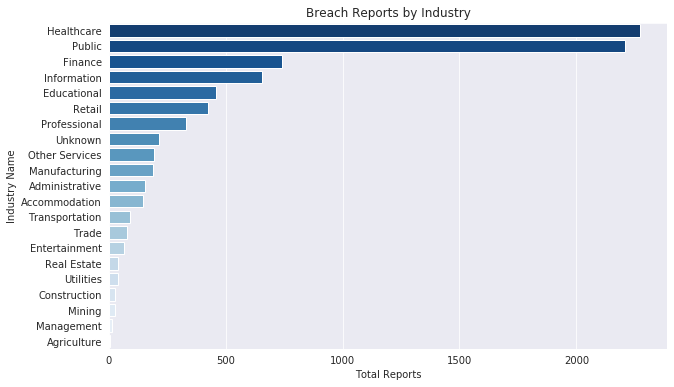

In [34]:
# for a in cst.ACTIONS:
#     adf[a] = vdf_loss[vdf_loss[a]==True]
    
# adf['action.Environmental']
# adf['action.Hacking']['records_lost']
# # plt.hist(adf['action.Hacking']['records_lost'])
# plt.setscale("log")
# print(adf[cst.ACTIONS])
# sns.distplot(adf[cst.ACTIONS]['records_lost'])?
f, ax = plt.subplots(figsize=(10, 6), sharex=True)
vdf['victim.industry.name']
ax = sns.countplot(y = 'victim.industry.name', data=vdf, orient='h', saturation=.8, palette="Blues_r", order=vdf['victim.industry.name'].value_counts().index)
sns.set_style("darkgrid")
plt.title('Breach Reports by Industry')
plt.xlabel('Total Reports')
plt.ylabel('Industry Name')
plt.show()
vdf_final = vdf_loss.copy()
print()

In [ ]:
# def assign_bugs(row):
#     return row.loc['action.Malware'] | row['action.Hacking']
# vdf_final[{'action.Malware', 'action.Hacking'}]
# vdf_final.assign('action.Bugs' = lambda x: x['action.Hacking'] | x['action.Bugs'])
# vdf_final[vdf[{'action.Hacking', 'action.Malware'}]==True].index
vdf_final

In [ ]:
# vdf_final['action.']

In [ ]:
import logging
import dowhy
import pygraphviz
import dowhy.datasets, dowhy.plotter
try:
    from dowhy import CausalModel
except:
    print('Using DoWhy 0.1.1')
    from dowhy.do_why import CausalModel

In [ ]:
import sys
print(sys.version)

In [ ]:
# Create causal model with instrumental
print(vdf_final['records_lost'])

model = CausalModel(
    data = vdf_final,
    treatment = 'action.Bugs',
    outcome = 'records_lost',
    common_causes = ['action.Environmental', 'action.Error', 'action.Misuse', 'action.Physical', 'action.Social'],
    instruments = ['action.Hacking', 'action.Malware'],
    logging_level = logging.INFO
)
model.view_model(layout="dot")

In [ ]:
from IPython.display import Image, display
display(Image(filename="causal_model.png"))

We get a causal graph. Now identification and estimation is done. 

In [ ]:
identified_estimand = model.identify_effect(proceed_when_unidentifiable=True)
print(identified_estimand)

In [ ]:
estimate = model.estimate_effect(identified_estimand,
        method_name="backdoor.linear_regression" )
print("Causal Estimate is " + str(estimate.value))

In [ ]:
identified_estimand = model.identify_effect(proceed_when_unidentifiable=True)
print(identified_estimand)

## Method 1: Stratification

In [ ]:
causal_estimate = model.estimate_effect(identified_estimand,
        method_name="backdoor.propensity_score_stratification")
print(causal_estimate)
print("Causal Estimate is " + str(causal_estimate.value))
res_random = model.refute_estimate(identified_estimand, causal_estimate, method_name="random_common_cause",test_significance=True)

res_placebo=model.refute_estimate(identified_estimand, estimate,
        method_name="placebo_treatment_refuter", placebo_type="permute")

res_subset=model.refute_estimate(identified_estimand, estimate,
        method_name="data_subset_refuter", subset_fraction=0.9)

print(res_subset)
print(res_random)
print(res_subset)
# model.refute_estimate(identified_estimand, causal_estimate)
# res_random  = model.refute_estimate(identified_estimand, causal_estimate, method_name="random_common_cause")

## Method 2: Matching

In [ ]:
causal_estimate_match = model.estimate_effect(identified_estimand,
        method_name="backdoor.propensity_score_matching")
print(causal_estimate_match)
print("Causal Estimate is " + str(causal_estimate_match.value))

In [ ]:
res_random = model.refute_estimate(identified_estimand, causal_estimate, method_name="random_common_cause",test_significance=True)

res_placebo=model.refute_estimate(identified_estimand, estimate,
        method_name="placebo_treatment_refuter", placebo_type="permute")

res_subset=model.refute_estimate(identified_estimand, estimate,
        method_name="data_subset_refuter", subset_fraction=0.9)

print(res_subset)
print(res_random)
print(res_subset)